# Clustering Comparison Analysis

We run a clustering model on some subset of the data and measure the similarity of the produced clusterings.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [11, 6]

%matplotlib inline

In [2]:
# Read in data
data = pd.read_csv('../data/features/merged.csv')

In [3]:
# Read in beat boundaries
beats_gdf = gp.read_file('../data/geographies/Boundaries - Police Beats (current).geojson')
beats_gdf.drop(['beat', 'district', 'sector'], axis=1, inplace=True)
beats_gdf.columns = ['BEAT', 'geometry']
beats_gdf['BEAT'] = beats_gdf['BEAT'].astype(int)

## Create training data

In [4]:
# From here on out, we'll use a separate variable "training_data" for filtered data. 
# It's good not to overwrite the original 'data' variable
# in case we want to recover the filtered columns later.
training_data = data.copy()

### ... by filtering columns

In [5]:
# [ REPLACE THIS CODE TO DROP COLUMNS IF NECESSARY ]

# demo_columns = ['COMPLAINTS_BLACK','COMPLAINTS_HISPANIC','COMPLAINTS_WHITE','ISR_BLACK','ISR_WHITE','ISR_HISPANIC','UOF_HISPANIC','UOF_BLACK','UOF_WHITE','CENSUS_WHITE','CENSUS_BLACK','CENSUS_HISPANIC','CENSUS_MEDIAN INCOME', 'CENSUS_TOTAL POP']
# training_data = training_data.drop(demo_columns, axis=1)

# Drop all demographics
remove_cols = ['BLACK', 'WHITE', 'HISPANIC', 'CENSUS']
for dem in remove_cols:
    cols = [c for c in training_data.columns if dem in c]
    training_data.drop(cols, axis=1, inplace=True)
training_data.columns

Index(['BEAT', 'YEAR', 'COMPLAINTS_POLICE_SHOOTING', 'COMPLAINTS_TOTAL',
       'CRIME_TOTAL', 'CRIME_ARREST', 'CRIME_DOMESTIC', 'ISR_TOTAL_STOPS',
       'ISR_SEARCH', 'ISR_ARREST', 'UOF_TOTAL_COUNT', 'UOF_POLICE_W_WEAPON',
       'UOF_POLICE_WO_WEAPON'],
      dtype='object')

### .. by aggregating rows

For model selection, since we're eventually clustering by beat, we'll aggregate by summing all years together.


In [6]:
# [ REPLACE THIS CODE TO DROP ROWS IF NECESSARY ]

training_data = training_data.drop('YEAR',axis=1).groupby(by='BEAT').agg(np.sum)
training_data.head(2)

,COMPLAINTS_POLICE_SHOOTING,COMPLAINTS_TOTAL,CRIME_TOTAL,CRIME_ARREST,CRIME_DOMESTIC,ISR_TOTAL_STOPS,ISR_SEARCH,ISR_ARREST,UOF_TOTAL_COUNT,UOF_POLICE_W_WEAPON,UOF_POLICE_WO_WEAPON
BEAT,,,,,,,,,,,
111,0.0,25,8926,2217,196,2501,217,193.0,102,10,34
112,0.0,9,6570,1074,89,968,82,80.0,64,4,23


## Preprocess / Transform Data

In [7]:
from sklearn.preprocessing import StandardScaler
# Normalize columns
scaler = StandardScaler()
scaled_training_data = pd.DataFrame(scaler.fit_transform(training_data),\
    columns=training_data.columns)

In [8]:
# Do PCA
from util_clustering import generate_pca_data
N_TOP_PCA_COMPONENTS = 6 # See Model Selection.ipynb for why we chose this number.
pca_training_data, pca = generate_pca_data(scaled_training_data, N_TOP_PCA_COMPONENTS)

## Setup Best Model & Hyperparameters

In [9]:
from sklearn.cluster import KMeans

PARAM_N_CLUSTERS = 7 # See Model Selection.ipynb for why we chose this number.
cluster_model_params = {'n_clusters':PARAM_N_CLUSTERS, 'random_state':0}
cluster_model = KMeans()
cluster_model.set_params(**cluster_model_params)

KMeans(n_clusters=7, random_state=0)

## Run the model

In [10]:
cluster_labels = cluster_model.fit_predict(pca_training_data)
clustered_data = pd.concat([pca_training_data, pd.Series(cluster_labels, name='Cluster')], axis=1)

In [11]:
clustered_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Cluster
0,2.154153,-0.556139,1.204775,-1.169982,2.916138,-0.345154,6
1,-0.712959,-0.397213,0.825376,-0.792141,2.122832,-0.394202,3
2,-0.662858,-0.397982,0.398048,0.343189,1.169731,-0.530594,3
3,-0.783367,-0.285063,0.855373,0.000778,1.045543,-0.769667,3
4,-2.824287,0.650939,0.038874,0.125945,0.573302,-0.183643,0


# Summarize Clustering

## Size of the clusters

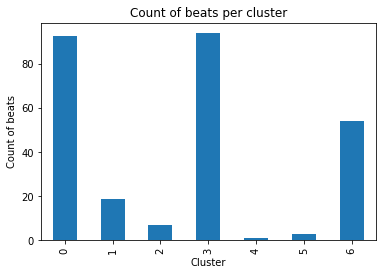

In [12]:
clustered_data['Cluster'].value_counts().sort_index().plot.bar()
plt.title('Count of beats per cluster')
plt.xlabel('Cluster')
plt.ylabel('Count of beats')
plt.savefig('../report/figures/beats_per_cluster.png', dpi=300)

## Characteristics of the clusters

In [13]:
# Merge in all data
cluster_training_data = clustered_data.merge(training_data.reset_index(drop=True), left_index=True, right_index=True)

/mnt/c/Users/jbleh/Desktop/UChicago/wsl/git/ml_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/c/Users/jbleh/Desktop/UChicago/wsl/git/ml_project/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='Cluster'>

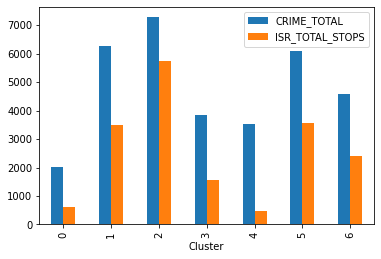

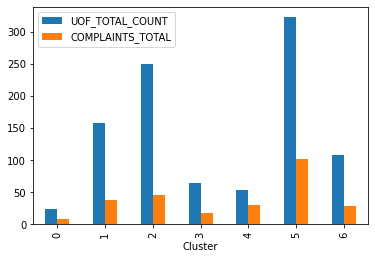

In [14]:
# Plot main features by cluster
sum_cols = ['CRIME_TOTAL', 'ISR_TOTAL_STOPS', 'UOF_TOTAL_COUNT', 'COMPLAINTS_TOTAL']
cluster_training_data.groupby(['Cluster'])['CRIME_TOTAL', 'ISR_TOTAL_STOPS'].mean().plot.bar()
cluster_training_data.groupby(['Cluster'])['UOF_TOTAL_COUNT', 'COMPLAINTS_TOTAL'].mean().plot.bar()

### Demographic characteristics

In [15]:
demog_data = data.copy()
demog_data = demog_data.drop('YEAR',axis=1).groupby(by='BEAT').agg(np.mean)
cols = [c for c in demog_data.columns if 'CENSUS' in c]
demog_data = demog_data[cols]

In [16]:
# Merge in all data
cluster_demo_data = clustered_data.merge(demog_data.reset_index(drop=True), left_index=True, right_index=True)

In [17]:
cluster_demo_data.groupby(['Cluster'])[cols].mean()

,CENSUS_TOTAL POP,CENSUS_WHITE,CENSUS_BLACK,CENSUS_HISPANIC,CENSUS_MEDIAN INCOME
Cluster,,,,,
0,11899.999471,0.654589,0.132538,0.281664,72914.794945
1,8145.835382,0.092679,0.835161,0.087108,36589.933954
2,6939.369913,0.062387,0.836081,0.131227,31529.972334
3,10698.198807,0.377202,0.436009,0.260717,55752.375120
4,6503.365610,0.109130,0.669530,0.035538,49635.333333
5,5161.243162,0.036352,0.930665,0.030824,28526.370933
6,7276.979664,0.161834,0.742764,0.152265,38656.734952


## Plot by beat

In [18]:
training_data.index

Int64Index([ 111,  112,  113,  114,  121,  122,  123,  124,  131,  132,
            ...
            2521, 2522, 2523, 2524, 2525, 2531, 2532, 2533, 2534, 2535],
           dtype='int64', name='BEAT', length=271)

In [19]:
cluster_labels.shape

(271,)

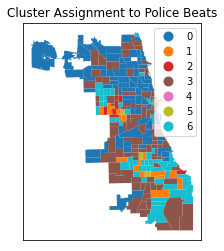

In [20]:
cluster_df = pd.DataFrame({'BEAT':training_data.index, 'Cluster':cluster_labels})
cluster_df['Cluster'] = cluster_df['Cluster'].astype(str)
beats_gdf.merge(cluster_df, on='BEAT').plot(column='Cluster', legend=True)
plt.title('Cluster Assignment to Police Beats')
plt.xticks([])
plt.yticks([])
plt.savefig('../report/figures/cluster_assignment_to_beats.png', dpi=300)

# Compare Clusters

## Define functions

### Functions to run clustering

In [21]:
def create_training_data_year(data, remove_cols, year):
    # Create training data
    training_data = data.copy()
    
    # filter columns
    for dem in remove_cols:
        cols = [c for c in training_data.columns if dem in c]
        training_data.drop(cols, axis=1, inplace=True)
        
    # filter by year
    training_data = training_data[training_data['YEAR']==year]
    training_data.drop('YEAR',axis=1)
    return training_data

In [22]:
def pre_process(training_data):
    # Normalize columns
    scaler = StandardScaler()
    scaled_training_data = pd.DataFrame(scaler.fit_transform(training_data),\
        columns=training_data.columns)
    
    # Do PCA
    N_TOP_PCA_COMPONENTS = 6 # See Model Selection.ipynb for why we chose this number.
    pca_training_data, pca = generate_pca_data(scaled_training_data, N_TOP_PCA_COMPONENTS)
    return pca_training_data

In [23]:
def setup_and_run_model(pca_training_data):
    # Setup model
    PARAM_N_CLUSTERS = 7 # See Model Selection.ipynb for why we chose this number.
    cluster_model_params = {'n_clusters':PARAM_N_CLUSTERS, 'random_state': 0} # Set random state so we get same result
    cluster_model = KMeans()
    cluster_model.set_params(**cluster_model_params)
    
    # run model
    cluster_labels = cluster_model.fit_predict(pca_training_data)
    clustered_data = pd.concat([pca_training_data, pd.Series(cluster_labels, name='Cluster')], axis=1)
    return cluster_labels, clustered_data

In [24]:
def get_clusters(training_data):
    pca_training_data = pre_process(training_data)
    cluster_labels, clustered_data = setup_and_run_model(pca_training_data)
    return cluster_labels, clustered_data    

### Functions to compute similarity

In [25]:
def get_match_mat(labels):
    # create list of lists, where each sublist is list of bools if there is a match
    final_list = [] 
    for a in labels:
        col_list = []
        for b in labels:
            col_list.append(a==b)
        final_list.append(col_list)
    return np.array(final_list)

In [26]:
def get_pct_match(mat1, mat2, n):
    total_matches = np.sum(mat1 & mat2)
    # remove diagonal matches, and divide by two to only count a match once (matrix is symmetric)
    actual_matches = (total_matches - n) / 2
    max_matches = max(((np.sum(mat1) - n )/2), ((np.sum(mat2) - n) /2))
    percent_match = actual_matches / max_matches
    return percent_match

In [27]:
def get_sim_clusters(labels1, labels2):
    n = len(labels1)
    mat1 = get_match_mat(labels1)
    mat2 = get_match_mat(labels2)
    return get_pct_match(mat1, mat2, n)

## Compare across different years

In [28]:
years = [2016, 2017, 2018, 2019]

In [29]:
remove_cols = ['BLACK', 'WHITE', 'HISPANIC', 'CENSUS']

result_df = pd.DataFrame()
for year1 in years:
    training_data_1 = create_training_data_year(data, remove_cols, year1)
    _, clustered_data_1 = get_clusters(training_data_1) # We are subsetting the labels later
    
    row_dict = {}

    for year2 in years:
        # Get clusters
        training_data_2 = create_training_data_year(data, remove_cols, year2)
        _, clustered_data_2 = get_clusters(training_data_2)

        # Merge on beat and extract new cluster labesl only for those that match
        merge_clusters = clustered_data_1.merge(clustered_data_2, left_index=True, right_index=True)
        cluster_labels_1 = merge_clusters['Cluster_x']
        cluster_labels_2 = merge_clusters['Cluster_y']

        # Compare
        sim_score = get_sim_clusters(cluster_labels_1, cluster_labels_2)
        row_dict[year2] = sim_score
    result_df = result_df.append(row_dict, ignore_index=True)


In [30]:
result_df.index = years
result_df

,2016,2017,2018,2019
2016,1.000000,0.340580,0.359140,0.328529
2017,0.340580,1.000000,0.404870,0.312057
2018,0.359140,0.404870,1.000000,0.358817
2019,0.328529,0.312057,0.358817,1.000000


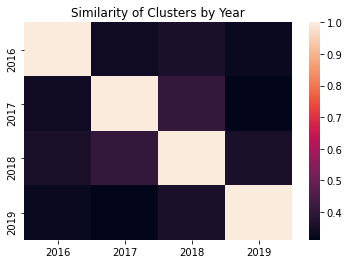

In [31]:
sns.heatmap(result_df)
plt.title('Similarity of Clusters by Year')
plt.savefig('../report/figures/similarity_by_year.png', dpi=300)

## Compare by race

Note- this doesn't work because we need >6 features to do pca then cluster on first 6 PCs.  Unsure if even valid to use that model.

In [32]:
def create_training_data_race(data, race):
    # Create training data
    training_data = data.copy()
    
    # filter columns
    cols = [c for c in training_data.columns if race in c]
    cols = [c for c in cols if 'CENSUS' not in c]
    cols.extend(['BEAT', 'YEAR'])
    training_data = training_data[cols]
        
    # Sum by year
    training_data = training_data.drop('YEAR',axis=1).groupby(by='BEAT').agg(np.sum)
    return training_data

In [33]:
black = create_training_data_race(data, 'BLACK')

In [34]:
black

,COMPLAINTS_BLACK,ISR_BLACK,UOF_BLACK
BEAT,,,
111,16,1908.0,79
112,5,752.0,59
113,11,1246.0,83
114,4,619.0,27
121,2,170.0,7
...,...,...,...
2531,23,1601.0,88
2532,21,2477.0,74
2533,17,1680.0,84
